# Should change Tkf below

In [1]:
import importlib
import time
import os
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import integrate
from scipy import interpolate

# Should change Tkf below

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
tune_name = 'e2'

save_dir = 'dt_05_2'

home = os.path.expanduser('~')
save_dir = os.path.join(
    home,
    'Documents/python_code/multi_loc/notebooks/',
    save_dir)
    
this_path = os.path.join(save_dir, 'Z_GT.npy')
Zgt = np.load(this_path)

this_path = os.path.join(save_dir, 'Z0_ens.npy')
Z0ens = np.load(this_path)

this_path = os.path.join(save_dir, 't_gt.npy')
t_gt = np.load(this_path)

this_path = os.path.join(save_dir, 't_lr.npy')
t_lr = np.load(this_path)

this_path = os.path.join(save_dir, 'run_vars.pkl')
with open(this_path, mode='rb') as f:
    run_vars = pickle.load(f)

In [6]:
for key, value in run_vars.items():
    print(key + ' = ' + str(value))
    exec(key + '=value')

Nz = 960
K = 32
I = 12
F = 14.0
b = 1.0
c = 0.37
alpha = 0.12414383561643835
beta = 0.013746194824961947
coarse = 8
Nez = 20
Nex = 500
dt_rk = 0.0020833333333333333
dt_lr = 0.1
dt_gt = 0.0020833333333333333
Tic = 24.0
Tlr = 4000
Tgt = 250


# Should change Tkf below

In [7]:
tune_dir = os.path.join(save_dir, tune_name)
if not os.path.exists(tune_dir):
    os.mkdir(tune_dir)

dt_trial_rk = 0.05/24
dt_kf = 0.05
dt_save = None
Tkf = Tgt/5  ######## Change this (I forgot) #######
Tspin_index = 500
Tspin = dt_kf * Tspin_index

alpha_range = np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3], dtype='float')
loc_range = np.array([2, 5, 10, 15, 20, 25, 30, 35, 40], dtype='float')


R_sd = 0.3
everyH = 2
Hz = np.eye(Nz)[::everyH]
Ny = Hz.shape[0]
Rz = np.eye(Ny) * R_sd**2

coarse_obs_dict = {'dt_trial_rk': dt_trial_rk,
                 'dt_kf': dt_kf,
                 'dt_save': dt_save,
                 'Tkf': Tkf,
                 'Tspin': Tspin,
                 'alpha_range': alpha_range,
                 'loc_range': loc_range,
                 'R_sd': R_sd,
                 'everyH': everyH,
                 'Hz': Hz,
                 'Rz': Rz}

this_path = os.path.join(tune_dir, 'coarse_obs_dict.pkl')
with open(this_path, mode='wb') as f:
    pickle.dump(coarse_obs_dict, f)

In [8]:
Nobs = int(Tkf/dt_kf) + 1
t_kf = np.linspace(0, Tkf, Nobs)

Ngt = int(Tgt/dt_gt) + 1
t_gt = np.linspace(0, Tgt, Ngt)
index_Tkf = int(Tkf/dt_gt) + 1

every_t = int(dt_kf/dt_gt)

if not np.allclose(t_kf, t_gt[0:index_Tkf:every_t]):
    print('They do not match')

In [9]:
Zloc = np.arange(Nz)

Zgt_ts = xr.DataArray(Zgt[:, 0:index_Tkf:every_t].copy(),
                      dims=('loc', 'time'),
                      coords={'loc': Zloc,
                              'time': t_kf})
Zobs_ts = Zgt[::everyH, 0:index_Tkf:every_t].copy()
Zobs_ts += np.random.multivariate_normal(np.zeros(Ny), Rz, Zobs_ts.shape[1]).T
Zobs_ts = xr.DataArray(Zobs_ts,
                       dims=('loc', 'time'),
                       coords={'loc': Zloc[::everyH],
                               'time': t_kf})
this_path = os.path.join(tune_dir, 'Zobs_ts.nc')
Zobs_ts.to_netcdf(this_path)
# del Zgt

In [10]:
importlib.reload(assimilate)
importlib.reload(utilities)


rmse_array_f = np.ones([alpha_range.size, loc_range.size]) * np.nan
std_array_f = rmse_array_f.copy()

rmse_array_a = rmse_array_f.copy()
std_array_a = rmse_array_f.copy()

stdrd_dir = os.path.join(tune_dir, 'stdrd_loc')
if not os.path.exists(stdrd_dir):
    os.mkdir(stdrd_dir)
time0 = time.time()
for alpha_count, this_alpha in enumerate(alpha_range):
    for loc_count, this_loc in enumerate(loc_range):
        this_folder_name = f'inf_{alpha_count:04}_loc_{loc_count:04}'
        this_dir_name = os.path.join(stdrd_dir, this_folder_name)
        if not os.path.exists(this_dir_name):
            os.mkdir(this_dir_name)
        print('alpha: ', this_alpha, '; loc: ', this_loc)
        print(this_dir_name)

        rho_Zc = np.arange(Nz)
        rho_Zc = np.minimum(np.abs(Nz - rho_Zc)%Nz, rho_Zc)
        rho_Zc = np.exp(-(rho_Zc**2)/(2*this_loc**2))
        rho_Zc = sp.linalg.circulant(rho_Zc)
#         imshow(rho_Zc)
        
        this_path = os.path.join(this_dir_name, 'rho0z')
        np.save(this_path, this_loc)
        
        this_path = os.path.join(this_dir_name, 'alpha')
        np.save(this_path, this_alpha)

        cycle_dict = {'Z0ens': Z0ens,
                      'Zobs_ts': Zobs_ts,
                      'Rz': Rz, 'Hz': Hz,
                      'Tkf': Tkf,
                      'dt_kf': dt_kf,
                      'dt_rk': dt_trial_rk,
                      'rho_Z': rho_Zc,
                      'rho0_Z': this_loc,
                      'infl': this_alpha,
                      'K': K,
                      'I': I,
                      'F': F,
                      'b': b,
                      'c': c,
                      'alpha': alpha,
                      'beta': beta}
        try:
            returned_dict = assimilate.cycle_KF_LM3_stdrd(**cycle_dict)
            mu_f = returned_dict['mu_f']
            std_f = returned_dict['std_f']

            mu_a = returned_dict['mu_a']
            std_a = returned_dict['std_a']

            this_path = os.path.join(this_dir_name, 'mu_f.nc')
            mu_f.to_netcdf(this_path)

            this_path = os.path.join(this_dir_name, 'std_f.nc')
            std_f.to_netcdf(this_path)

            this_path = os.path.join(this_dir_name, 'mu_a.nc')
            mu_a.to_netcdf(this_path)

            this_path = os.path.join(this_dir_name, 'std_a.nc')
            std_a.to_netcdf(this_path)


            rmse_array_f[alpha_count, loc_count] = (np.sqrt(
                ((mu_f - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
                                          .isel(time=slice(Tspin_index, None)).mean())
            rmse_array_a[alpha_count, loc_count] = (np.sqrt(
                ((mu_a - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
                                          .isel(time=slice(Tspin_index, None)).mean())
            std_array_f[alpha_count, loc_count] = (np.sqrt((std_f**2).mean(axis=0))
                                                  .isel(time=slice(Tspin_index, None)).mean())
            std_array_a[alpha_count, loc_count] = (np.sqrt((std_a**2).mean(axis=0))
                                                  .isel(time=slice(Tspin_index, None)).mean())
            print('rmse_f: ', rmse_array_f[alpha_count, loc_count])
            print('rmse_a: ', rmse_array_a[alpha_count, loc_count])
        except:
            print(this_dir_name, ' has failed.')
        time1 = time.time()
        print(f'{((time1 - time0)/60):0.3} minutes')
        print()
        time0 = time1
            

alpha:  0.0 ; loc:  2.0
/Users/harty/Documents/python_code/multi_loc/notebooks/dt_05_2/e2/stdrd_loc/inf_0000_loc_0000
rmse_f:  0.10027146769201621
rmse_a:  0.0935312796864615
5.64 minutes

alpha:  0.0 ; loc:  5.0
/Users/harty/Documents/python_code/multi_loc/notebooks/dt_05_2/e2/stdrd_loc/inf_0000_loc_0001
rmse_f:  1.505853896804735
rmse_a:  1.4471858745873325
5.31 minutes

alpha:  0.0 ; loc:  10.0
/Users/harty/Documents/python_code/multi_loc/notebooks/dt_05_2/e2/stdrd_loc/inf_0000_loc_0002
rmse_f:  1.8148247687796035
rmse_a:  1.7624484523268928
5.4 minutes

alpha:  0.0 ; loc:  15.0
/Users/harty/Documents/python_code/multi_loc/notebooks/dt_05_2/e2/stdrd_loc/inf_0000_loc_0003
rmse_f:  1.978630502251084
rmse_a:  1.9201533247590643
5.08 minutes

alpha:  0.0 ; loc:  20.0
/Users/harty/Documents/python_code/multi_loc/notebooks/dt_05_2/e2/stdrd_loc/inf_0000_loc_0004
rmse_f:  2.0339469228752853
rmse_a:  1.977981620994332
5.01 minutes

alpha:  0.0 ; loc:  25.0
/Users/harty/Documents/python_code/

rmse_f:  1.257807885784249
rmse_a:  1.230449511621072
7.79 minutes

alpha:  0.2 ; loc:  40.0
/Users/harty/Documents/python_code/multi_loc/notebooks/dt_05_2/e2/stdrd_loc/inf_0004_loc_0008
rmse_f:  1.4121389490695306
rmse_a:  1.385829627378886
7.86 minutes

alpha:  0.25 ; loc:  2.0
/Users/harty/Documents/python_code/multi_loc/notebooks/dt_05_2/e2/stdrd_loc/inf_0005_loc_0000
rmse_f:  0.17056927801247387
rmse_a:  0.16697754385603014
8.37 minutes

alpha:  0.25 ; loc:  5.0
/Users/harty/Documents/python_code/multi_loc/notebooks/dt_05_2/e2/stdrd_loc/inf_0005_loc_0001
rmse_f:  0.1294057314367816
rmse_a:  0.125283203403811
8.11 minutes

alpha:  0.25 ; loc:  10.0
/Users/harty/Documents/python_code/multi_loc/notebooks/dt_05_2/e2/stdrd_loc/inf_0005_loc_0002
rmse_f:  0.10888059571551807
rmse_a:  0.10432918436241409
5.86 minutes

alpha:  0.25 ; loc:  15.0
/Users/harty/Documents/python_code/multi_loc/notebooks/dt_05_2/e2/stdrd_loc/inf_0005_loc_0003
rmse_f:  0.10000049293208904
rmse_a:  0.0953121968405

In [43]:
# ## Add on 

# importlib.reload(assimilate)
# importlib.reload(utilities)


# rmse_array_f = np.ones([alpha_range.size, loc_range.size]) * np.nan
# std_array_f = rmse_array_f.copy()

# rmse_array_a = rmse_array_f.copy()
# std_array_a = rmse_array_f.copy()

# stdrd_dir = os.path.join(tune_dir, 'stdrd_loc')
# if not os.path.exists(stdrd_dir):
#     os.mkdir(stdrd_dir)
    
# alpha_count = 5
# this_alpha = 0.12
# for loc_count, this_loc in enumerate(loc_range):
#     this_folder_name = f'inf_{alpha_count:04}_loc_{loc_count:04}'
#     this_dir_name = os.path.join(stdrd_dir, this_folder_name)
#     if not os.path.exists(this_dir_name):
#         os.mkdir(this_dir_name)
#     print('alpha: ', this_alpha, '; loc: ', this_loc)
#     print(this_dir_name)

#     rho_Zc = np.arange(Nz)
#     rho_Zc = np.minimum(np.abs(Nz - rho_Zc)%Nz, rho_Zc)
#     rho_Zc = np.exp(-(rho_Zc**2)/(2*this_loc**2))
#     rho_Zc = sp.linalg.circulant(rho_Zc)
# #         imshow(rho_Zc)

#     this_path = os.path.join(this_dir_name, 'rho0z')
#     np.save(this_path, this_loc)

#     this_path = os.path.join(this_dir_name, 'alpha')
#     np.save(this_path, this_alpha)

#     cycle_dict = {'Z0ens': Z0ens,
#                   'Zobs_ts': Zobs_ts,
#                   'Rz': Rz, 'Hz': Hz,
#                   'Tkf': Tkf,
#                   'dt_kf': dt_kf,
#                   'dt_rk': dt_trial_rk,
#                   'rho_Z': rho_Zc,
#                   'rho0_Z': this_loc,
#                   'alpha': this_alpha}
#     try:
#         returned_dict = assimilate.cycle_KF_LM3_stdrd(**cycle_dict)
#         mu_f = returned_dict['mu_f']
#         std_f = returned_dict['std_f']

#         mu_a = returned_dict['mu_a']
#         std_a = returned_dict['std_a']

#         this_path = os.path.join(this_dir_name, 'mu_f.nc')
#         mu_f.to_netcdf(this_path)

#         this_path = os.path.join(this_dir_name, 'std_f.nc')
#         std_f.to_netcdf(this_path)

#         this_path = os.path.join(this_dir_name, 'mu_a.nc')
#         mu_a.to_netcdf(this_path)

#         this_path = os.path.join(this_dir_name, 'std_a.nc')
#         std_a.to_netcdf(this_path)


#         rmse_array_f[alpha_count, loc_count] = (np.sqrt(
#             ((mu_f - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
#                                       .isel(time=slice(Tspin_index, None)).mean())
#         rmse_array_a[alpha_count, loc_count] = (np.sqrt(
#             ((mu_a - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
#                                       .isel(time=slice(Tspin_index, None)).mean())
#         std_array_f[alpha_count, loc_count] = (np.sqrt((std_f**2).mean(axis=0))
#                                               .isel(time=slice(Tspin_index, None)).mean())
#         std_array_a[alpha_count, loc_count] = (np.sqrt((std_a**2).mean(axis=0))
#                                               .isel(time=slice(Tspin_index, None)).mean())
#         print('rmse_f: ', rmse_array_f[alpha_count, loc_count])
#         print('rmse_a: ', rmse_array_a[alpha_count, loc_count])
#     except:
#         print(this_dir_name, ' has failed.')

In [11]:
this_path = os.path.join(stdrd_dir, 'rmse_array_f.npy')
np.save(this_path, rmse_array_f)

this_path = os.path.join(stdrd_dir, 'std_array_f.npy')
np.save(this_path, std_array_f)

this_path = os.path.join(stdrd_dir, 'rmse_array_a.npy')
np.save(this_path, rmse_array_a)

this_path = os.path.join(stdrd_dir, 'std_array_a.npy')
np.save(this_path, std_array_a)

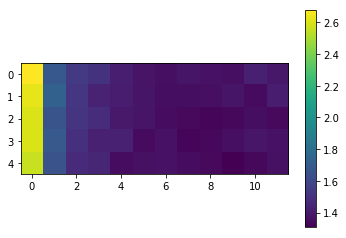

In [12]:
imshow(rmse_array_f)